<a href="https://colab.research.google.com/github/GWasee/Final-Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/Final Project"
!ls

/content/drive/MyDrive/Colab Notebooks/Final Project
config.yaml  datasets  data.yaml  Photos  runs	test  train  valid  Videos  yolov8s.pt


Importing required Libraries

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Dataset Description






Fruit Images for Object Detection

available on kaggle => https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection


- 240 images in train folder. 60 images in test folder.

- 3 different fruits:

    - Apple

    - Banana

    - Orange

The labels are in xml format, which is Extensible markup language.Storing image dataset labels in XML format is quite common. XML provides a clear, hierarchical structure which is ideal for representing the complex data associated with image labels. This includes not just the class of the object, but potentially a wealth of other information like bounding box coordinates, object IDs, and additional metadata.


# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.


## Heirarchy of Folders correction

Defining paths to train and test folders.

In [ ]:
test_dir = '/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/test_zip/test'
train_dir = '/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/train_zip/train'



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

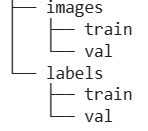


Making directories according to above struture of folders

In [ ]:
#import os
#run it once for making directories

#os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images/train')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images/val')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels/train')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels/val')

In [ ]:
#set the paths to labels and images directory
label_dir= "/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels"
image_dir="/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images"

Copy XML files and jpg files from the train folder to the folders created.

In [ ]:
#import shutil
#run it once for copying!
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), os.path.join(label_dir, "train"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"train", new_filename), "JPEG")
        #shutil.copy(os.path.join(train_dir, file), os.path.join(image_dir, "train"))


#Copy XML files and jpg files from the test folder to the folders created.
for file in os.listdir(test_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(test_dir, file), os.path.join(label_dir, "val"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(test_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"val", new_filename), "JPEG")
        #shutil.copy(os.path.join(test_dir, file), os.path.join(image_dir, "val"))


Visualizing somme pictures from the dataset

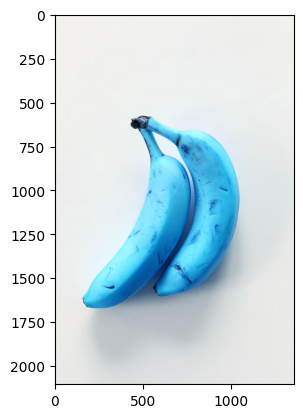

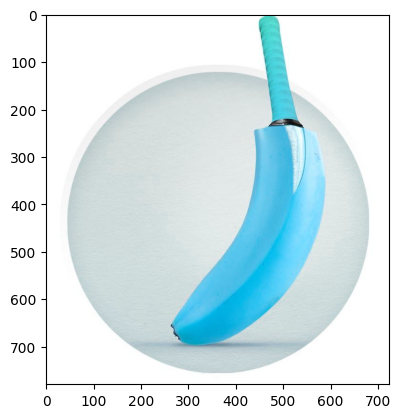

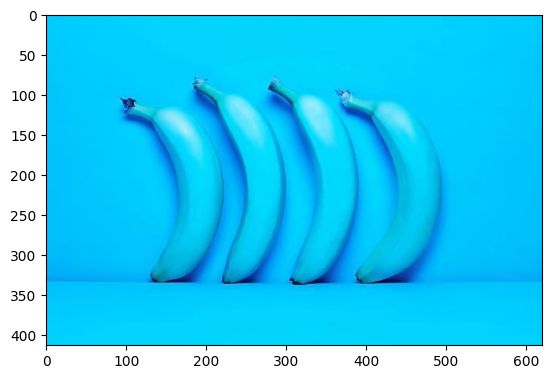

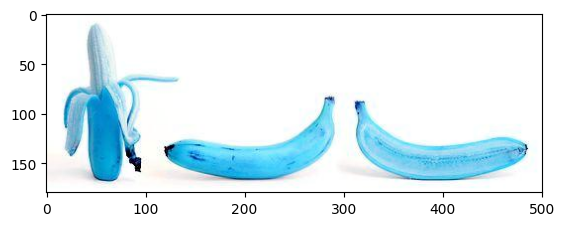

In [ ]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

## Creating Text files for labels
Creating Dataframes from .xml files, from which we will eventually create .txt file for each image


In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

Streaming output truncated to the last 5000 lines.
<Element 'xmin' at 0x78484e292160>
<Element 'ymin' at 0x78484e292660>
<Element 'xmax' at 0x78484e292b10>
<Element 'ymax' at 0x78484e292200>
/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels/train/apple_14.xml
<Element 'annotation' at 0x78484e27ce00>
<Element 'folder' at 0x78484e27cef0>
<Element 'filename' at 0x78484e2931f0>
<Element 'path' at 0x78484e293a10>
<Element 'source' at 0x78484e2932e0>
<Element 'database' at 0x78484e2933d0>
<Element 'size' at 0x78484e292930>
<Element 'width' at 0x78484e292980>
<Element 'height' at 0x78484e2923e0>
<Element 'depth' at 0x78484e293380>
<Element 'segmented' at 0x78484e291f80>
<Element 'object' at 0x78484e2934c0>
<Element 'name' at 0x78484e292a20>
<Element 'pose' at 0x78484e2924d0>
<Element 'truncated' at 0x78484e293d30>
<Element 'difficult' at 0x78484e292de0>
<Element 'bndbox' at 0x78484e292750>
<Element 'xmin' at 0x78484e292840>
<Element 'ymin' at 0x78484e2928e0>
<Element 'xma

Doing the same for validation data labels.


In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir+"/val" + '/*.xml')):

    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df2['label'] += [label]
                    df2['width'] += [width]
                    df2['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df2['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df2['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df2['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df2['ymax'] += [ymax]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax
0,apple_77,apple,300,229,71,60,175,164
1,apple_77,apple,300,229,12,22,105,111
2,apple_77,apple,300,229,134,23,243,115
3,apple_77,apple,300,229,107,126,216,229
4,apple_77,apple,300,229,207,138,298,229


Visualizing one of the image in train set with the bounding box

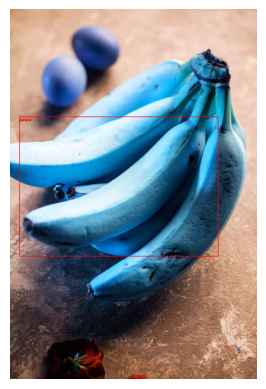

In [ ]:
index= 10 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

Checking to see if the above image has bounding boxes around other apples or not.

In [ ]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

        name   label  width  height  xmin  ymin  xmax  ymax
9   banana_5  banana   1200    1800   366   575  1173  1514
10  banana_5  banana   1200    1800    46   524  1011  1202
11  banana_5  banana   1200    1800     1   399   899   889
12  banana_5  banana   1200    1800   164   212   945   791


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    117 non-null    object
 1   label   117 non-null    object
 2   width   117 non-null    int64 
 3   height  117 non-null    int64 
 4   xmin    117 non-null    int64 
 5   ymin    117 non-null    int64 
 6   xmax    117 non-null    int64 
 7   ymax    117 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 7.4+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [ ]:
print(train_df['label'].unique())
print(val_df['label'].unique())

['banana' 'orange' 'apple']
['apple' 'banana' 'orange']


We need to map labels to class_ids required for YOLO

In [ ]:
label_map = { 'orange': 0,
            'apple': 1,
            'banana': 2}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [ ]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,banana_54,banana,1024,768,77,230,841,572,2
1,banana_54,banana,1024,768,363,211,1013,754,2
2,banana_54,banana,1024,768,37,187,793,485,2
3,banana_53,banana,0,0,4,92,409,434,2
4,banana_52,banana,501,180,117,82,302,174,2


convertig the bounding box format to the one required by YOLO:




In [ ]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [ ]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
0,banana_54,banana,1024,768,77,230,841,572,2,0.448242,0.522135,0.746094,0.445312
1,banana_54,banana,1024,768,363,211,1013,754,2,0.671875,0.628255,0.634766,0.707031
2,banana_54,banana,1024,768,37,187,793,485,2,0.405273,0.437500,0.738281,0.388021
3,banana_53,banana,0,0,4,92,409,434,2,inf,inf,inf,inf
4,banana_52,banana,501,180,117,82,302,174,2,0.418164,0.711111,0.369261,0.511111


Deleting all the sample with Nan values in training and validation data

In [ ]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)



before deleting (train data):  (465, 13)
after deleting(train_data):  (420, 13)
before deleting (val data):  (117, 13)
after deleting(val data):  (110, 13)


converting the dataframe to type *str* (string) to be stored in text files.

In [ ]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [ ]:
filtered_df = train_df[train_df['name'] == train_df["name"][100]]
(filtered_df.head(15))

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
97,apple_65,apple,800,600,70,25,290,226,1,0.225,0.20916666666666667,0.275,0.335
98,apple_65,apple,800,600,35,217,253,453,1,0.18,0.5583333333333333,0.2725,0.3933333333333333
99,apple_65,apple,800,600,183,177,382,411,1,0.353125,0.49,0.24875,0.39
100,apple_65,apple,800,600,605,298,787,513,1,0.87,0.6758333333333333,0.2275,0.35833333333333334
101,apple_65,apple,800,600,498,370,675,567,1,0.733125,0.7808333333333334,0.22125,0.3283333333333333
102,apple_65,apple,800,600,333,239,574,463,1,0.566875,0.585,0.30125,0.37333333333333335
103,apple_65,apple,800,600,191,350,373,543,1,0.3525,0.7441666666666666,0.2275,0.32166666666666666
104,apple_65,apple,800,600,443,425,655,598,1,0.68625,0.8525,0.265,0.28833333333333333


In [ ]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

## Checking Missing Files

Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [ ]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)



In [ ]:
print(len(image_files_val), "  =  ", len(label_files_val))

56   =   56


In [ ]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [ ]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

# Custom object detection using YOLO

First install and import

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/107.7 GB disk)


In [4]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [ ]:
model = YOLO('yolov8s.pt') # pretrained model

The detailed architecture of the model can be seen from:


In [ ]:
model

In [ ]:
%%writefile config.yaml

train: /content/drive/MyDrive/Colab Notebooks/Final Project/train
val: /content/drive/MyDrive/Colab Notebooks/Final Project/valid
test: /content/drive/MyDrive/Colab Notebooks/Final Project/test

nc: 5
names: ['Damaged potato', 'Defected potato', 'Diseased-fungal potato', 'Potato', 'Sprouted potato']

roboflow:
  workspace: vegetable-quality-detection
  project: potato-detection-3et6q
  version: 11
  license: CC BY 4.0
  url: https://universe.roboflow.com/vegetable-quality-detection/potato-detection-3et6q/dataset/11


# %%writefile config.yaml
# path: /content/drive/MyDrive/Colab Notebooks/Final Project
# train: /content/drive/MyDrive/Colab Notebooks/Final Project/train
# test: /content/drive/MyDrive/Colab Notebooks/Final Project/test
# val: /content/drive/MyDrive/Colab Notebooks/Final Project/valid

# # Classes
# nc: 4 # replace based on your dataset's number of classes

# # Class names
# # replace all class names with your own classes' names
# names:
#   0: potato
#   1: sprouted potato
#   2: damaged potato
#   3: defected potato

Overwriting config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [ ]:
model.train(data="data.yaml",epochs=1,patience=5,batch=30, lr0=0.001,imgsz=416)

Ultralytics YOLOv8.2.0 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=1, time=None, patience=5, batch=30, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

train: Scanning /content/drive/MyDrive/Colab Notebooks/Final Project/train/labels.cache... 7170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7170/7170 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 12, len(boxes) = 26482. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/Final Project/valid/labels.cache... 575 images, 0 backgrounds, 0 corrupt: 100%|██████████| 575/575 [00:00<?, ?it/s]

Plotting labels to runs/detect/train6/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train6
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G       1.03      1.639      1.207        165        416: 100%|██████████| 239/239 [2:11:42<00:00, 33.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [06:24<00:00, 38.43s/it]


                   all        575       1827      0.606      0.498      0.533      0.374

1 epochs completed in 2.306 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 22.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [03:45<00:00, 22.53s/it]


                   all        575       1827      0.606      0.498      0.533      0.374
        Damaged potato        575        221      0.446       0.24      0.278      0.195
       Defected potato        575        236      0.885      0.347      0.571      0.392
Diseased-fungal potato        575        425      0.815      0.393      0.593      0.464
                Potato        575        646      0.665      0.725      0.776      0.569
       Sprouted potato        575        299      0.218      0.786      0.449      0.248
Speed: 1.1ms preprocess, 357.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cd8ec0cb340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics YOLOv8.2.0 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/Final Project/valid/labels.cache... 575 images, 0 backgrounds, 0 corrupt: 100%|██████████| 575/575 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [03:49<00:00, 11.46s/it]


                   all        575       1827      0.606      0.498      0.533      0.374
        Damaged potato        575        221      0.446       0.24      0.278      0.195
       Defected potato        575        236      0.885      0.347      0.571      0.392
Diseased-fungal potato        575        425      0.815      0.393      0.593      0.464
                Potato        575        646      0.665      0.725      0.776      0.569
       Sprouted potato        575        299      0.218      0.786      0.449      0.248
Speed: 1.3ms preprocess, 363.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train62


0.49821131944733377

Showing confusion matrix, that is already stored in detect/train folder

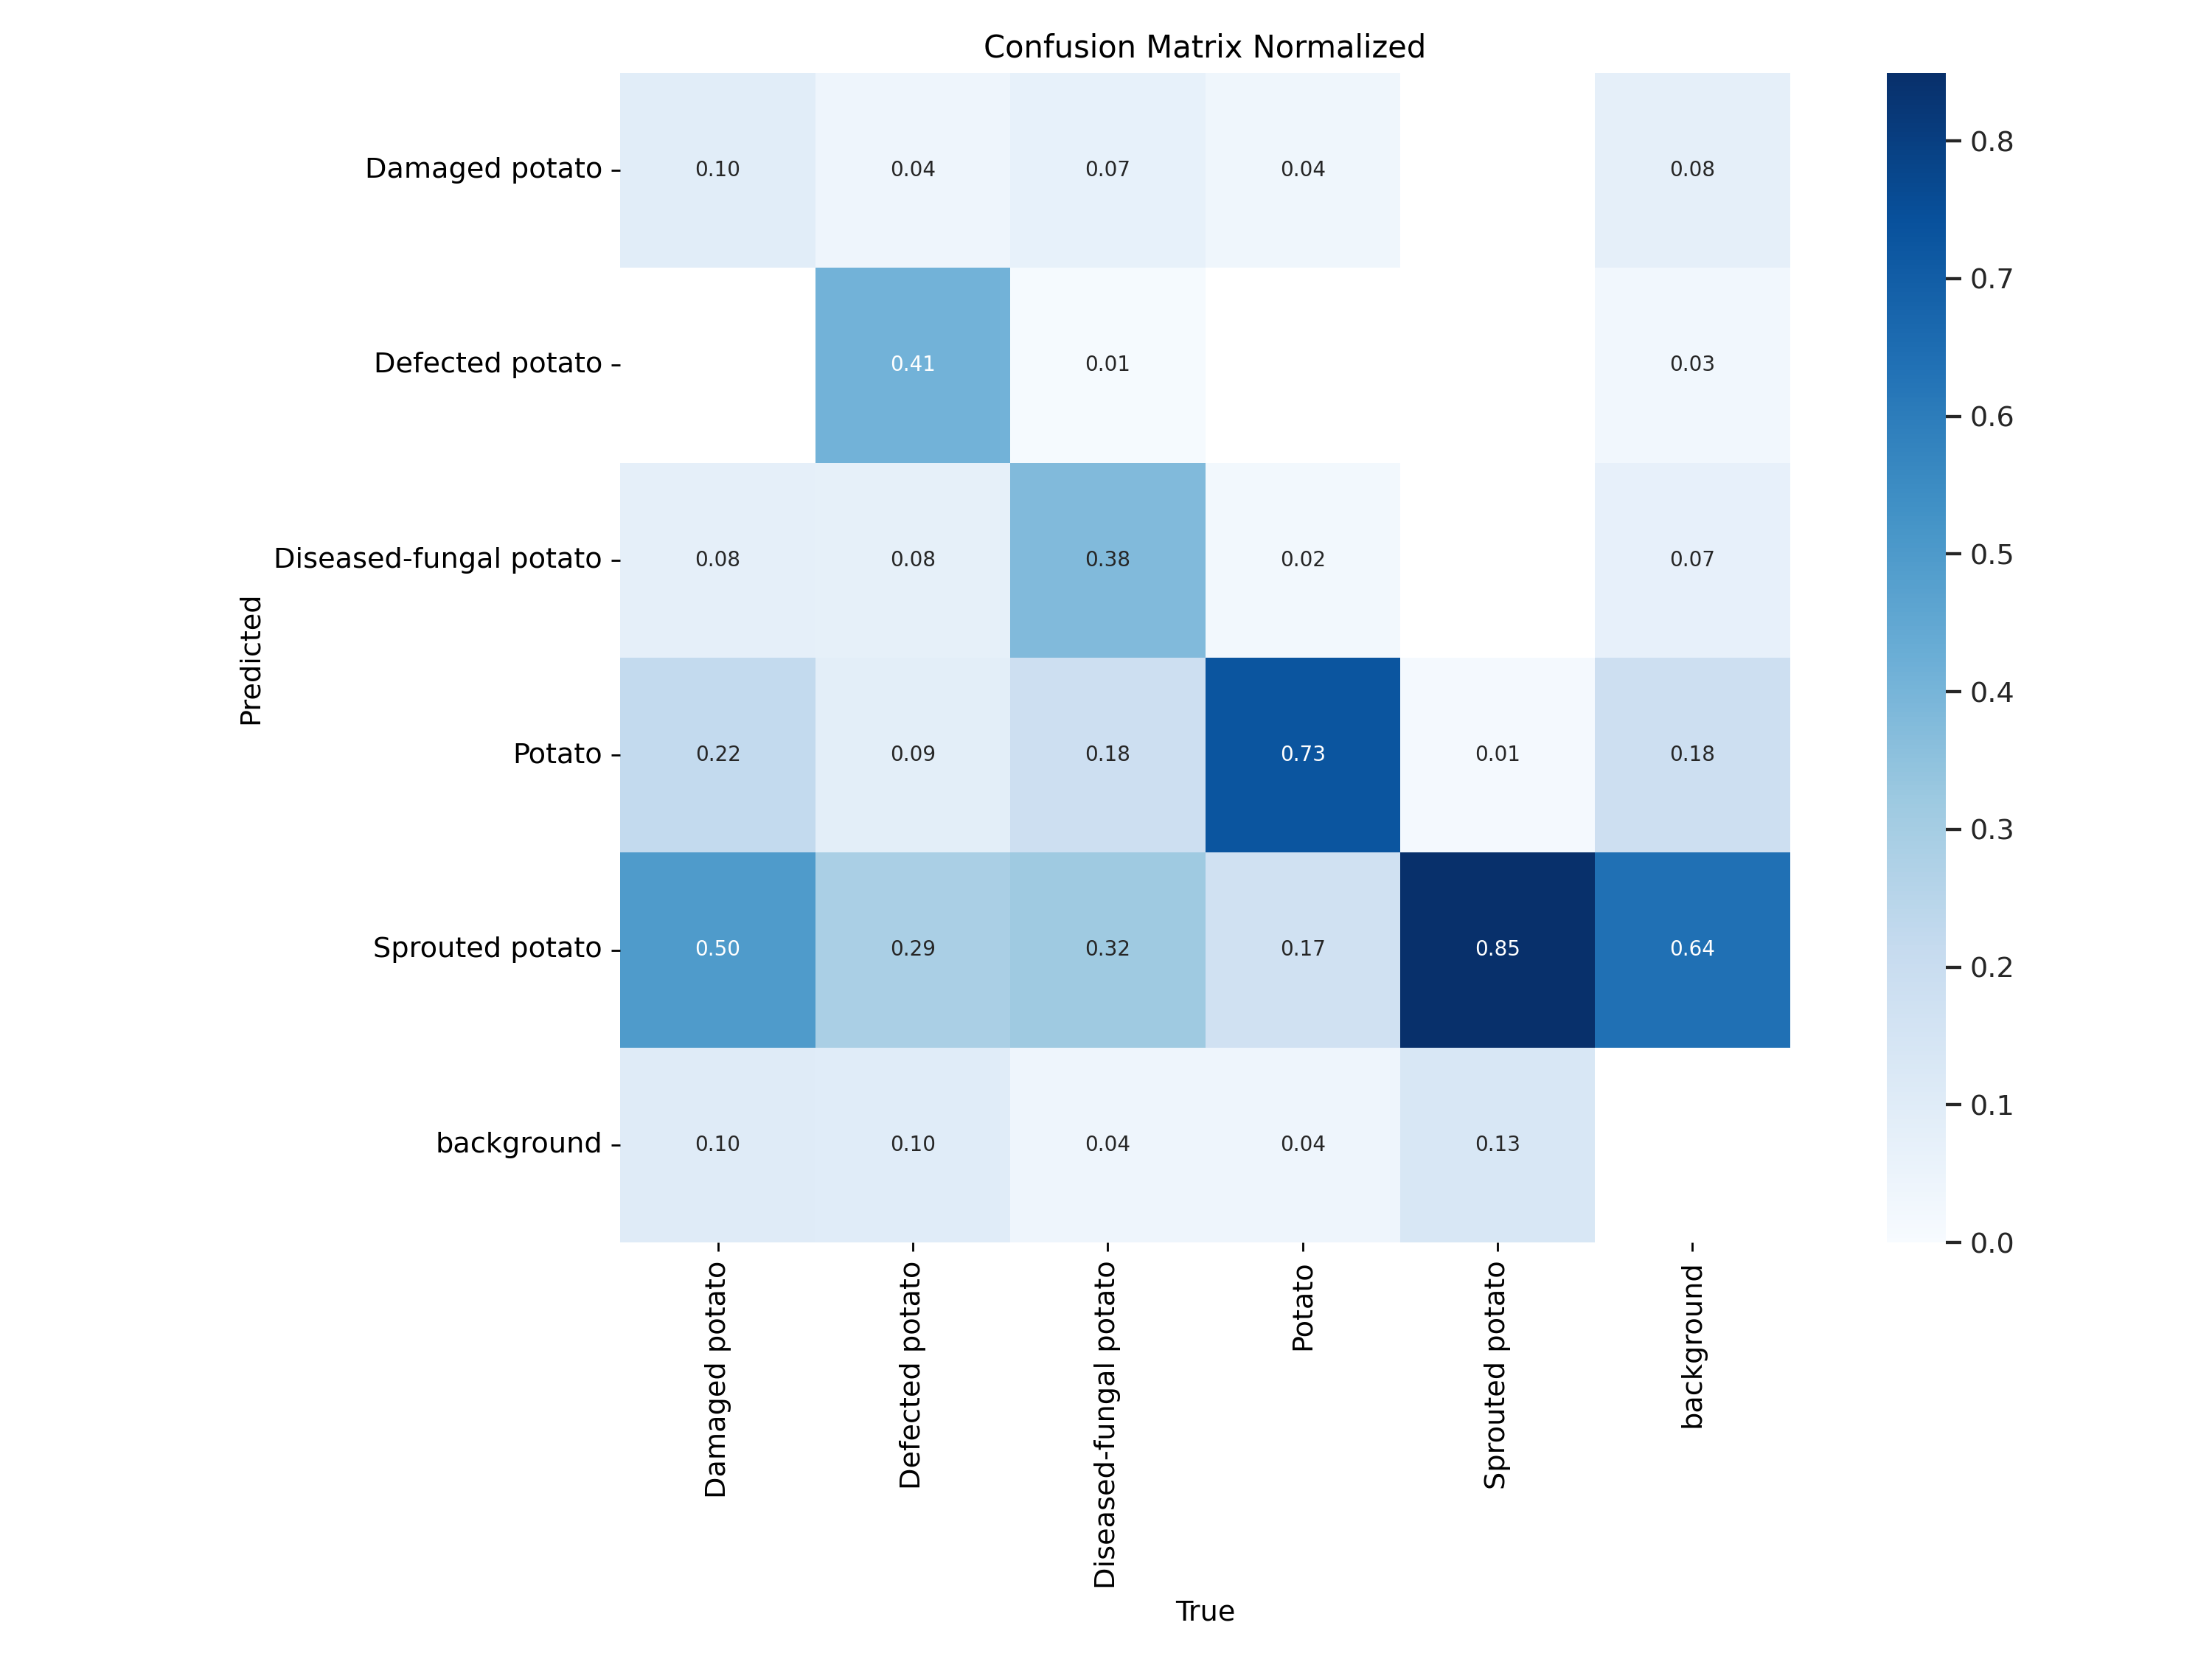

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('/content/drive/MyDrive/Colab Notebooks/Final Project/runs/detect/train6/confusion_matrix_normalized.png')

##Prediction

#Download Youtube Video

In [48]:
!pip install pytube  # for downloading videos
import pytube  # for downloading YouTube videos
import cv2  # for video processing
import torch  # PyTorch, which is already likely used by YOLO

In [49]:
from pytube import YouTube

def download_youtube_video(youtube_url, output_path):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(file_extension='mp4').first()  # Get the first stream that is MP4
    stream.download(output_path=output_path)
    print(f'Downloaded video: {stream.default_filename}')
    return output_path + '/' + stream.default_filename


In [95]:
# URL of the YouTube video
video_url = 'https://www.youtube.com/watch?v=4uxu-9sNIvE'  # Youtube video's URL
downloaded_video_path = download_youtube_video(video_url, '/content/drive/MyDrive/Colab Notebooks/Final Project/Videos')
print(f"Video downloaded to: {downloaded_video_path}")
VideoInfo.from_video_path(downloaded_video_path)

Downloaded video: GLOBAL  POTATO GRADING AND SORTING LINE 9824240130.mp4
Video downloaded to: /content/drive/MyDrive/Colab Notebooks/Final Project/Videos/GLOBAL  POTATO GRADING AND SORTING LINE 9824240130.mp4


VideoInfo(width=640, height=360, fps=29, total_frames=1486)

##Predict Using Code

In [69]:

# # Load the custom-trained YOLO model
# model = YOLO("/content/drive/MyDrive/Colab Notebooks/Final Project/runs/detect/train6/weights/best.pt")

# def process_video(video_path, model, output_path):
#     # Start capturing video
#     cap = cv2.VideoCapture(video_path)
#     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = int(cap.get(cv2.CAP_PROP_FPS))

#     # Define the codec and create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' or 'XVID'
#     out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Convert frame to RGB (YOLOv5 model expects RGB images)
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#         # Perform detection using the model
#         results = model(frame_rgb)

#         # Convert results to original frame BGR format for display and saving output
#         frame_bgr = cv2.cvtColor(results.render()[0], cv2.COLOR_RGB2BGR)

#         # Write the frame with detections to output video file
#         out.write(frame_bgr)

#     # Release everything if job is finished
#     cap.release()
#     out.release()
#     print("Output video is saved to", output_video_path)

# # Set paths
# video_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/Videos/GLOBAL  POTATO GRADING AND SORTING LINE 9824240130.mp4'  # Path to input video
# output_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/Videos/output2.mp4'  # Path to save output video

# # Process the video and save the output
# process_video(video_path, model, output_path)


In [67]:
# model = YOLO("/content/drive/MyDrive/Colab Notebooks/Final Project/runs/detect/train6/weights/best.pt")  # load a custom model

# # Predict with the model with any image from internet?
# results = model('/content/drive/MyDrive/Colab Notebooks/Final Project/shutterstock_1508472857-660x330.jpg', save=True)

In [68]:
# # SHOW THE IMAGE STORED
# %matplotlib inline
# from PIL import Image

# Image.open('/content/drive/MyDrive/Colab Notebooks/Final Project/runs/detect/predict7/shutterstock_1508472857-660x330.jpg')

##Installing ByteTrack, Supervision & Tracking utils

In [18]:
HOME = "/content/drive/MyDrive/Colab Notebooks/Final Project"

!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [19]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [20]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [21]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [45]:
from typing import List

import numpy as np

np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [12]:
# import supervision as sv

# # Define the path to the video and the model weights
# VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Final Project/Videos/GLOBAL  POTATO GRADING AND SORTING LINE 9824240130.mp4"

# # Load the custom-trained YOLO model
# model = YOLO("/content/drive/MyDrive/Colab Notebooks/Final Project/runs/detect/train6/weights/best.pt")
# model.fuse()

# video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

# import cv2
# import numpy as np
# import supervision as sv
# from ultralytics import YOLO

# # Define the path to the video and the model weights
# VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Final Project/Videos/GLOBAL  POTATO GRADING AND SORTING LINE 9824240130.mp4"
# MODEL_WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/Final Project/runs/detect/train6/weights/best.pt"

# # Load the YOLOv8 model
# model = YOLO(MODEL_WEIGHTS_PATH)


# VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=640, height=360, fps=29, total_frames=1486)

#Video Path and Modeling best model

In [23]:
model = YOLO("/content/drive/MyDrive/Colab Notebooks/Final Project/runs/detect/train6/weights/best.pt")
model.fuse()

Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


In [62]:
CLASS_NAMES_DICT = model.model.names    #Classes available in the model

CLASS_ID = [0, 3]  #Classes being detected for the video

print(CLASS_ID, CLASS_NAMES_DICT,)



[0, 3] {0: 'Damaged potato', 1: 'Defected potato', 2: 'Diseased-fungal potato', 3: 'Potato', 4: 'Sprouted potato'}


In [96]:
VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Final Project/Videos/GLOBAL  POTATO GRADING AND SORTING LINE 9824240130.mp4"


VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=640, height=360, fps=29, total_frames=1486)


0: 256x416 1 Damaged potato, 2 Potatos, 197.7ms
Speed: 1.7ms preprocess, 197.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)


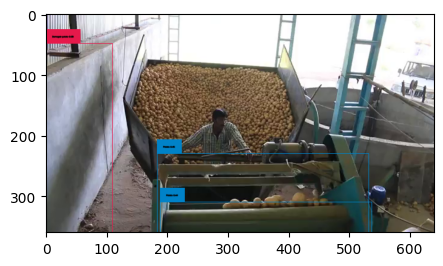

In [97]:
# create frame generator
generator = get_video_frames_generator(VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.1)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (5, 5))

## Predict and annotate whole video

In [98]:
# Counting line
#removed for the lack of high res video of potato on conveyor
LINE_START = Point(-50, -300)
LINE_END = Point(-600, -180)

TARGET_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Final Project/Videos/RESULTS.mp4"

In [99]:
VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=640, height=360, fps=29, total_frames=1486)

In [100]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/1486 [00:00<?, ?it/s]


0: 256x416 1 Damaged potato, 2 Potatos, 150.1ms
Speed: 1.6ms preprocess, 150.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 Damaged potato, 2 Potatos, 148.4ms
Speed: 1.6ms preprocess, 148.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 Damaged potato, 2 Potatos, 161.4ms
Speed: 2.3ms preprocess, 161.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 Damaged potato, 2 Potatos, 175.9ms
Speed: 1.7ms preprocess, 175.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 Damaged potato, 3 Potatos, 170.2ms
Speed: 1.6ms preprocess, 170.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 Damaged potato, 4 Potatos, 157.1ms
Speed: 2.4ms preprocess, 157.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 4 Potatos, 167.5ms
Speed: 2.1ms preprocess, 167.5ms inference, 0.8ms postprocess per image at shape (1, 3,

In [ ]:
# # Define the output path for the annotated video
# OUTPUT_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Final Project/Videos/output_video_annotated.mp4"

# # Process the video
# sv.process_video(source_path=VIDEO_PATH, target_path=OUTPUT_VIDEO_PATH, callback=process_frame)
